# Verifying the data conversion process 

### (Lat, Lon) -> (Range, Bearing) -> (x, y)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

In [2]:
AIRPORT = "kmsy"
BASE_DIR = f'../datasets/amelia/traj_data_a10v7/raw_trajectories/{AIRPORT}'

traj_files = [os.path.join(BASE_DIR, f) for f in os.listdir(BASE_DIR)]

data = pd.read_csv(traj_files[0])
data.head()

,Frame,ID,Altitude,Speed,Heading,Lat,Lon,Range,Bearing,Type,Interp,x,y
0,0,2483774,0.0,0.0,275.388794,29.99748,-90.27548,1.366176,-1.189107,2.0,[ORG],0.508885,-1.267862
1,1,2483774,0.0,0.0,275.388794,29.99748,-90.27548,1.366176,-1.189107,2.0,[ORG],0.508885,-1.267862
2,2,2483774,0.0,0.0,275.388794,29.99748,-90.27548,1.366176,-1.189107,2.0,[ORG],0.508885,-1.267862
3,3,2483774,0.0,0.0,275.388794,29.99748,-90.27548,1.366176,-1.189107,2.0,[ORG],0.508885,-1.267862
4,4,2483774,0.0,0.0,275.388794,29.99748,-90.27548,1.366176,-1.189107,2.0,[ORG],0.508885,-1.267862


# Check if (X,Y)'s are correct

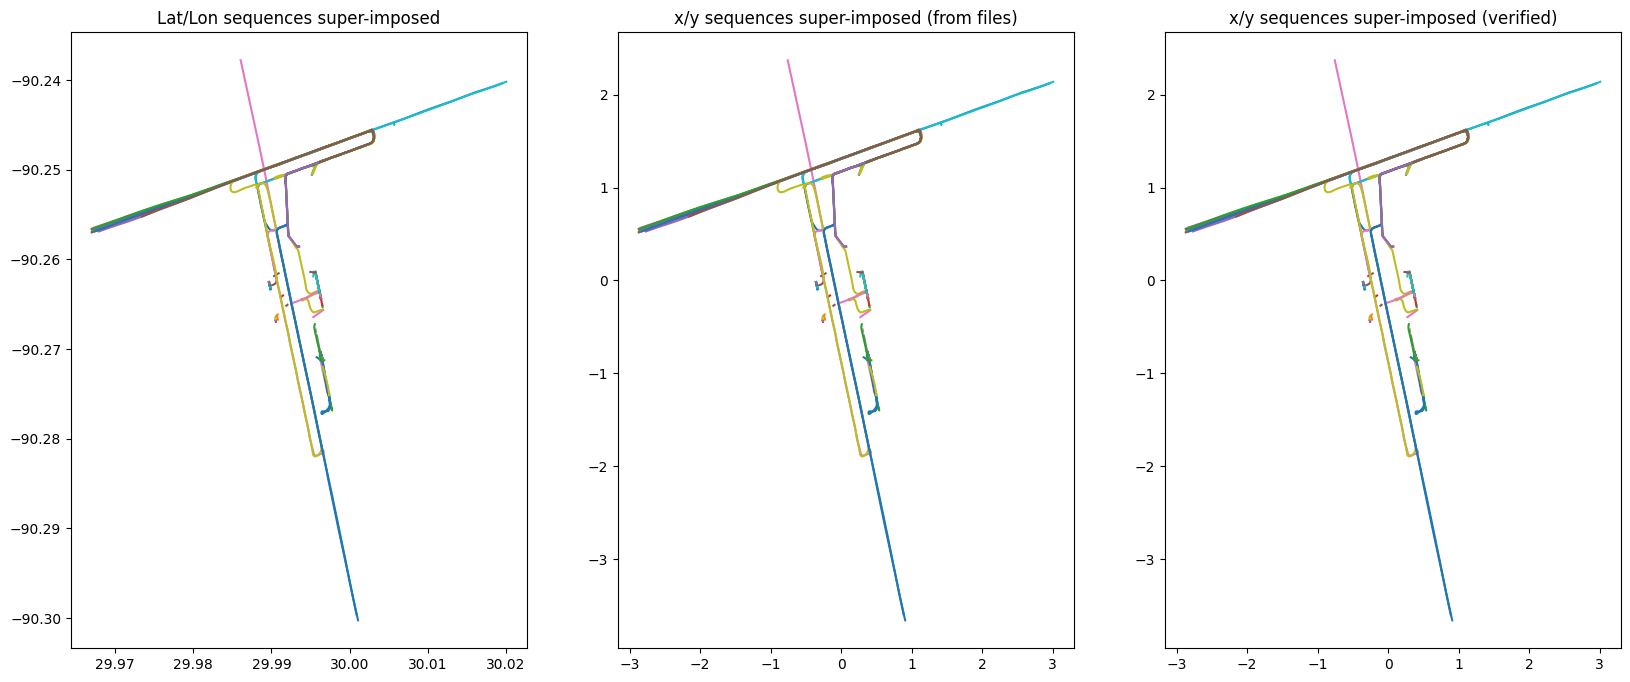

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

agent_ids = data.ID.unique()
for agent_id in agent_ids:
    agent_seq = data[data.ID == agent_id]

    # plot (lat, lon)
    ax[0].plot(agent_seq.Lat, agent_seq.Lon)
    ax[0].set_title('Lat/Lon sequences super-imposed')

    # plot current (x, y)
    ax[1].plot(agent_seq.x, agent_seq.y)
    ax[1].set_title('x/y sequences super-imposed (from files)')

    r = agent_seq.Range.to_numpy()
    b = agent_seq.Bearing.to_numpy()
    # if AIRPORT == "kewr":
    #     x = r * np.cos(np.radians(b))
    #     y = r * np.sin(np.radians(b))
    # else:
    x = r * np.cos(b)
    y = r * np.sin(b)
        
    ax[2].plot(x, y)
    ax[2].set_title('x/y sequences super-imposed (verified)')

## Fix (x, y)

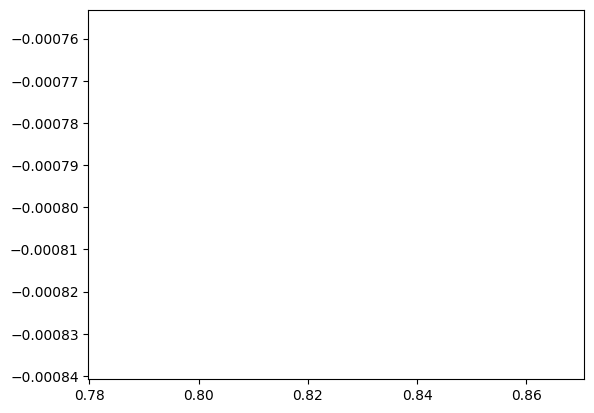

In [11]:
range = agent_seq.Range.to_numpy()
bearing = agent_seq.Bearing.to_numpy()
x = range * np.cos(np.radians(bearing))
y = range * np.sin(np.radians(bearing))
plt.plot(x, y)

# Fix one file:

In [31]:
data.head()

,Frame,ID,Altitude,Speed,Heading,Lat,Lon,Range,Bearing,x,y
0,0,2954,12.5,22.0000,343.948975,40.70261,-74.15670,1.930806,44.312887,1.381560,1.348815
1,0,3278,12.5,5.0000,179.497375,40.68393,-74.17292,0.693287,-178.183245,-0.692939,-0.021979
2,0,49,12.5,2.6875,147.191528,40.67482,-74.18339,1.930910,-151.976966,-1.704528,-0.907193
3,0,3812,12.5,0.0000,26.109009,40.68238,-74.17504,0.888150,-166.906652,-0.865060,-0.201200
4,0,278,12.5,6.3750,333.230867,40.70130,-74.15743,1.784553,46.159509,1.236076,1.287146


In [32]:
r = data.Range.to_numpy()
b = data.Bearing.to_numpy()
x = r * np.cos(np.radians(b))
y = b * np.sin(np.radians(b))

data['x'] = x
data['y'] = y

data.head()

,Frame,ID,Altitude,Speed,Heading,Lat,Lon,Range,Bearing,x,y
0,0,2954,12.5,22.0000,343.948975,40.70261,-74.15670,1.930806,44.312887,1.381560,30.955929
1,0,3278,12.5,5.0000,179.497375,40.68393,-74.17292,0.693287,-178.183245,-0.692939,5.648951
2,0,49,12.5,2.6875,147.191528,40.67482,-74.18339,1.930910,-151.976966,-1.704528,71.402805
3,0,3812,12.5,0.0000,26.109009,40.68238,-74.17504,0.888150,-166.906652,-0.865060,37.810737
4,0,278,12.5,6.3750,333.230867,40.70130,-74.15743,1.784553,46.159509,1.236076,33.293510


In [33]:
r_from_xy = np.sqrt(x**2 + y**2)
b_from_xy = np.degrees(np.arctan2(y, x))

assert np.isclose(r, r_from_xy).all(), f"Range values are not equal"
assert np.isclose(b, b_from_xy).all(), f"Bearing values are not equal"

AssertionError: Range values are not equal

# Correct all files

In [ ]:
base_path = "./boeing/airports/raw_trajectories/"

in_path = os.path.join(base_path, f"{AIRPORT}_incorrect")

out_path = os.path.join(base_path, f"{AIRPORT}")
os.makedirs(out_path, exist_ok=True)

for dir in ['all', 'train', 'test', 'val']:
    print(dir)
    in_path_set = os.path.join(in_path, dir)
    files = os.listdir(in_path_set)

    out_path_set = os.path.join(out_path, dir)
    os.makedirs(out_path_set, exist_ok=True)

    for f in tqdm(files):
        in_file = os.path.join(in_path_set, f)
    
        data = pd.read_csv(in_file)

        # compute correct [x, y]
        range = data.Range.to_numpy()
        bearing = data.Bearing.to_numpy()
        x = range * np.cos(np.radians(bearing))
        y = range * np.sin(np.radians(bearing))

        # make sure that translating back to [range, bearing] is correct. 
        range_from_xy = np.sqrt(x**2 + y**2)
        bearing_from_xy = np.degrees(np.arctan2(y, x))
        assert np.isclose(range, range_from_xy).all(), f"Range values are not equal"
        assert np.isclose(bearing, bearing_from_xy).all(), f"Bearing values are not equal"

        # if correct, update and save new values
        data['x'] = x
        data['y'] = y

        out_file = os.path.join(out_path_set, f)
        # data.to_csv(out_file, index=False)